# Work with the data reduction submodule

## Authors
Zhiyuan Ma

## Learning Goals
* Learn the concept of ``RuntimeContext``, which is the primary interface to run data related tasks.

* Reduce an example TolTEC observation.

## Keywords
Simulation; Data reduction

## Summary

**Note**: The tolteca provides a commandline interface for running the simuator and reduction, which
hides a lot of implementation details and is suitable for light users. This notebook aims to provide
a in-depth overview of some of the key components behind the scene. The commandline interface tutorial
can be found here: https://github.com/toltec-astro/tolteca/blob/main/docs/tolteca/toltec_simu_tutorial.md

In this tutorial, we will create a simulated TolTEC observation and reduce it.

To proceed, we need to first setup a tolteca working directory (workdir).

A tolteca workdir is a directory prepared by tolteca, which contains special subdirs
recognized by the tolteca, as well as a set of runtime config
files in YAML format.

Tolteca workdir provides the user experience similar to a python virutal environment.
User can create many workdirs and each has its own configuration setup for a
certain task or project. The configurations are picked up automatically when invoking
``tolteca ...`` command in the shell when in a particular tolteca workdir.

Under the hood, the in-memory representation of a workdir in tolteca is an instance of
`tolteca.utils.RuntimeContext`. All funtionalities related to tolteca workdir are defined
as some methods of this class (or some subclass of it). The runtime context is the
core object that user would be dealing with in tolteca when working in the IPython
prompt or Jupyter notebook.

The first part of the tutorial gives a walk through of the concept of runtime context and
workdir. We will show how to setup from scratch a workdir for running tolteca.simu module
from Cell 1-7. Note that in the tutorial, we create the workdir in a temporary folder, however,
one is encouraged to setup the workdir in his or her own user space, to match the actual use
case. The tolteca.cli module provides a command ``tolteca setup`` to setup a workdir in the
shell:
```
    $ cd /path/to/hold/workdir
    $ tolteca setup example_tolteca_workdir
    $ cd example_tolteca_workdir && ls  # check the content
    50_setup.yaml  bin/  cal/  log/
```
then one can just copy over one of the example configurations for the simulator
stored in [``tolteca/data/examples/``](https://github.com/toltec-astro/tolteca/tree/master/tolteca/data/examples) to the workdir. Once the workdir is in place and has all
the necessary bits, on can jump right into the second part of the tutorial starting [Cell 8](#cell8).

## Installing Citlali

``Citlali`` is the TolTEC data reduction pipeline engine, which needs to be installed in order to run the part of this tutorial related to data reduction (Cell 22). You'll need to revise the path to the citlali executable in Cell 22 to make it avaliable to ``tolteca.reduce``. For instruction of installing citlali, visit https://github.com/toltec-astro/citlali.

## Let's first create a runtime context object.

To make the tutorial independent of any user's own system setup, we just use a temporary
directory here:

In [1]:
# import some common packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib widget
import astropy.units as u

import tempfile
from contextlib import ExitStack  # to manage the tempdir

es = ExitStack()
workdir = es.enter_context(tempfile.TemporaryDirectory())

from tolteca.utils import RuntimeContext

rc = RuntimeContext.from_dir(dirpath=workdir, create=True)

print(f'Created runtime context {rc}')
print(f'Config files in the rc: {rc.config_files}')

Created runtime context RuntimeContext(/private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf)
Config files in the rc: [PosixPath('/private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/50_setup.yaml')]


To load the config, just access the ``config`` attribute:

In [2]:
print(f'config: {rc.config}')

SchemaMissingKeyError: Missing key: 'setup'

The reason of the exception is that we have not "setup" the runtime context properly. The setup step is to "initialize" the workdir, so later tolteca runs can recognize the context. To setup,

In [3]:
rc.setup()

from tollan.utils.fmt import pformat_yaml  # pretty print the config
print(pformat_yaml(rc.config))


runtime:
  bindir: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/bin
  caldir: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/cal
  logdir: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/log
  rootpath: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf
  setup_file: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/50_setup.yaml
setup:
  created_at: 2021-06-19T01:54:14.106
  version: 0.1.dev323+g1c6dc6b



The ``setup()`` method also support adding custom records as follows (note the ``overwrite=True``, otherwise the ``setup()`` will not be on an already setup runtime context):

In [4]:
rc.setup(config={
    'my_info': {'foo': 'bar'},
    'setup': {'baz': 'boo'}
    }, overwrite=True)
print(pformat_yaml(rc.config))


my_info:
  foo: bar
runtime:
  bindir: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/bin
  caldir: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/cal
  logdir: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/log
  rootpath: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf
  setup_file: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/50_setup.yaml
setup:
  baz: boo
  created_at: 2021-06-19T01:54:14.328
  version: 0.1.dev323+g1c6dc6b



Now we have the workdir setup, we can go back and pretend that we already have a valid tolteca workdir, in which case we can just load the runtime context directly without needing to create and setup again (note how our custom records get loaded as well):

In [5]:
try:
    del rc  # just to make sure we don't get confused with the old rc object.
except Exception:
    pass
rc = RuntimeContext(rootpath=workdir)
print(f'Created runtime context {rc}')
print(f'Config files in the rc: {rc.config_files}')
print(f'Config:\n{pformat_yaml(rc.config)}')

Created runtime context RuntimeContext(/private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf)
Config files in the rc: [PosixPath('/private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/50_setup.yaml')]
Config:

my_info:
  foo: bar
runtime:
  bindir: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/bin
  caldir: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/cal
  logdir: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/log
  rootpath: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf
  setup_file: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/50_setup.yaml
setup:
  baz: boo
  created_at: 2021-06-19T01:54:14.328
  version: 0.1.dev323+g1c6dc6b



## Create simulated data

Tolteca.simu provides a set of tools to create simulated data. To run the simulator, we will need our workdir that we just setup, but with more information.

The tolteca.simu comes with its own subclass of `RuntimeContext`, namely, `SimulatorRuntime`. The simulator runtime manages simulator related configurations loaded from the workdir. To create the simulator runtime, we do the follows:

In [6]:
from tolteca.simu import SimulatorRuntime
rc = SimulatorRuntime(rootpath=workdir)
print(f'Created runtime context {rc}')
print(f'Config files in the rc: {rc.config_files}')
print(f'Config:\n{pformat_yaml(rc.config)}')

Created runtime context SimulatorRuntime(/private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf)
Config files in the rc: [PosixPath('/private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/50_setup.yaml')]


SchemaMissingKeyError: Missing key: 'simu'

The reason of the exception is that we have not "setup" the simulator properly. The simulator expects a branch of config entries under the key ``simu``, stored in one of the YAML files found in the workdir.

The tolteca.simu has a set of "built-in" configurations that one can use readily, one of which is 'toltec_point_source'. Let's dump this config to the workdir with file name "60_simu.yaml". Note the format ``\d+_.+.yaml``, this is the convention of the YAML config files to be recongnized by the tolteca runtime context. The files with lower number are overriden by those with higher number.

Note that in the example config, it refers to a filepath ``toltec_sources.asc`` in the ``sources`` list. This is an ASCII table that defines the point sources to be injected on the sky. We need also create this table.

In [7]:
from tolteca.simu import example_configs as cfgs
cfg = cfgs['toltec_point_source']
print(pformat_yaml(cfg))

import yaml
with open(rc.rootpath.joinpath('60_simu.yaml'), 'w') as fo:
    yaml.dump(cfg, fo)

# create the point source catalog
# we just add two sources here. The column names
# used matches with those in the source definition `colname_map`, whose
# keys (a1100, etc) matches with the `grouping: array_name` setting.
from astropy.table import Table
catalog = Table(rows=[
    ['s0', 92., -7., 30., 20., 10.,],
    ['s1', 92., -7.01, 10., 10., 10.,],
    ['s3', 92.01, -7., 100, 200, 300],
    ],
    names=['name', 'ra', 'dec', 'flux_a1100', 'flux_a1400', 'flux_a2000'],
    units=[None, u.deg, u.deg, u.mJy, u.mJy, u.mJy]
    )
catalog.write(rc.rootpath.joinpath('toltec_sources.asc'), format='ascii.ecsv')


simu:
  instrument:
    calobj: cal/calobj_default/index.yaml
    name: toltec
  jobkey: toltec_point_source
  mapping:
    length: '1. arcmin'
    n_scans: 40
    ref_frame: icrs
    rot: '0. deg'
    space: '1.5 arcsec'
    speed: '1. arcmin/s'
    t0: 2020-04-12 00:00:00
    t_turnover: '0.1 s'
    target: '92d -7d'
    type: tolteca.simu:SkyRasterScanModel
  obs_params:
    f_smp_data: '122. Hz'
    f_smp_mapping: '12 Hz'
    t_exp: '1 ct'
  sources:
    - colname_map:
        a1100: flux_a1100
        a1400: flux_a1400
        a2000: flux_a2000
        dec: dec
        name: name
        ra: ra
      filepath: toltec_sources.asc
      grouping: array_name
      type: point_source_catalog
    - atm_model_name: am_q50
      type: toltec_array_loading



Now we re-visit the ``config`` attribute of the simulator runtime. We should see the new 60_simu.yaml file is suceessfully picked up and no more complains about missing configuration keys.

<a id='cell8'></a>For those returning readers who already have a workdir setup with correct contents, you can start from this cell.

In [8]:
# If you already have a workdir at some path so you can ignore Cells 1-7 and jump in from here: 
# from tolteca.simu import SimulatorRuntime
# workdir = '/the/path/to/a/workdir/with/simu/configs'
# rc = SimulatorRuntime(rootpath=workdir)
print(f'Config:\n{pformat_yaml(rc.config)}')

Config:

my_info:
  foo: bar
runtime:
  bindir: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/bin
  caldir: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/cal
  logdir: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/log
  rootpath: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf
  setup_file: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/50_setup.yaml
setup:
  baz: boo
  created_at: 2021-06-19T01:54:14.328
  version: 0.1.dev323+g1c6dc6b
simu:
  instrument:
    calobj: cal/calobj_default/index.yaml
    name: toltec
  jobkey: toltec_point_source
  mapping:
    length: '1. arcmin'
    n_scans: 40
    ref_frame: icrs
    rot: '0. deg'
    space: '1.5 arcsec'
    speed: '1. arcmin/s'
    t0: 2020-04-12 00:00:00
    t_turnover: '0.1 s'
    target: '92d -7d'
    type: tolteca.simu:SkyRasterScanModel
  mapping_only: false
  obs_params:
    f_smp_data: 122.0 Hz
    f_smp_mapping: 12.0 

The simulator configuration defines the on-the-fly mapping pattern, the input sources, and the instrument to simulate. Under the hood, each of these aspects is managed by its own class which implements the related functionalities.

Let's take a look at the mapping model first. We can make a plot of the mapping pattern:

mapping model:
Model: SkyRasterScanModel
Inputs: ('t',)
Outputs: ('lon', 'lat')
Model set size: 1
Parameters:
    length space  n_scans rot   speed    t_turnover
    arcmin arcsec         deg arcmin / s     s     
    ------ ------ ------- --- ---------- ----------
       1.0    1.5    40.0 0.0        1.0        0.1
time to finish mapping: 43.9 s
mapping target: <SkyCoord (ICRS): (ra, dec) in deg
    (92., -7.)>


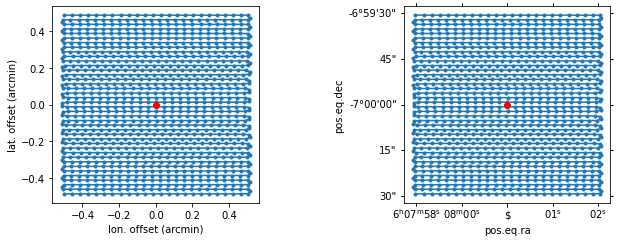

In [9]:

mapping = rc.get_mapping_model()
print(f'mapping model:\n{mapping}')
# the time to finish the mapping can be obtained from the mapping model
mapping_time = mapping.get_total_time()
print(f'time to finish mapping: {mapping_time}')
# to plot the pattern, let's genrate some sampling points
# For plotting, we just use a linspace grid here, but in the actual simulator run
# it makes use of the obs params "f_smp_mapping" as the sampling frequency
t = np.linspace(0, mapping_time, 1000)

mapping_offsets = mapping(t)  # this is the offsets from bore sight

# to evaluate mapping pattern around a coordinates, use evaluate_at
# The frame of input coordinates will be assumed for the offsets
# here the mapping target from the config is given in equitorial
# so the mapping will be along equitorial coordinate frame
target_coord = mapping.target
print(f'mapping target: {mapping.target}')

mapping_coords = mapping.evaluate_at(target_coord, t)

fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(wspace=0.7)
# the bore sight offsets
ax = fig.add_subplot(1, 2, 1)
ax.set_aspect('equal')
ax.plot(
    mapping_offsets[0].to_value(u.arcmin),
    mapping_offsets[1].to_value(u.arcmin),
    marker='.',
    )
ax.plot(0, 0, marker='o', color='red')  # the target
ax.set_xlabel('lon. offset (arcmin)')
ax.set_ylabel('lat. offset (arcmin)')

# the sky coords, which we need an fiducial wcs object
# to plot in the ref frame of target coords, i.e., ICRS
from astropy.wcs.utils import celestial_frame_to_wcs
w = celestial_frame_to_wcs(target_coord.frame)
# set the crval to target
w.wcs.crval = np.array([target_coord.ra.degree, target_coord.dec.degree])
ax = fig.add_subplot(1, 2, 2, projection=w)  # a WCSAxes plot, see https://docs.astropy.org/en/stable/visualization/wcsaxes/index.html
ax.set_aspect('equal')
ax.plot(
    mapping_coords.ra.degree,
    mapping_coords.dec.degree,
    transform=ax.get_transform('icrs'),
    marker='.',
    )
ax.plot(
    target_coord.ra.degree, target_coord.dec.degree,
    transform=ax.get_transform('icrs'),
    marker='o', color='red',
    )
ax.coords[0].set_ticklabel(exclude_overlapping=True)  # reduce the cluttering of tick labels.

For the input sources, the ``sources`` list specified in the simulator configs is parsed and a set of `tolteca.simu.base.SourceModel` subclass instances are created according to the ``type`` key. In this case, we only have one model with type ``point_source_catalog``. It is specified in format of an ASCII table, which we just created. Below is the snippet that renders the input point sources to FITS image HDUs as observed by the TolTEC instrument:

sources: [<SourceCatalogModel(name='/private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/toltec_sources.asc')>, {'a1100': <ArrayLoadingModel(name='a1100_loading')>, 'a1400': <ArrayLoadingModel(name='a1400_loading')>, 'a2000': <ArrayLoadingModel(name='a2000_loading')>}]
model class is:
<class 'tolteca.simu.base.SourceCatalogModel'>
Name: SourceCatalogModel
N_inputs: 2
N_outputs: 1
model data:
a1100 a1400 a2000  dec  name   ra 
 mJy   mJy   mJy   deg        deg 
----- ----- ----- ----- ---- -----
 30.0  20.0  10.0  -7.0   s0  92.0
 10.0  10.0  10.0 -7.01   s1  92.0
100.0 200.0 300.0  -7.0   s3 92.01
model source positions: <SkyCoord (ICRS): (ra, dec) in deg
    [(92.  , -7.  ), (92.  , -7.01), (92.01, -7.  )]>


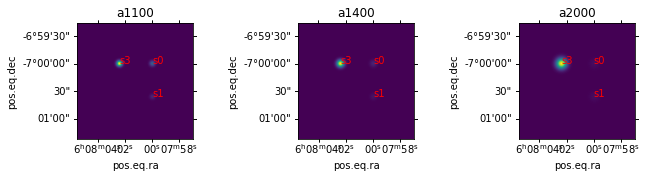

In [10]:
sources = rc.get_source_model()
print(f'sources: {sources}')
m_point_source = sources[0]  # take out the point source model and let's take a look
print(f'model class is:\n{type(m_point_source)}')
print(f'model data:\n{m_point_source.data}')
print(f'model source positions: {m_point_source.pos}')
# we can make a synetic image and plot by creating a SourceImageModel from the SourceCatalogModel
# to do this we need some beammodels and a pixelscale.
# we can use the toltec beammodels here, and assume a 1"/pix scale
from tolteca.simu.toltec import BeamModel
m_img = m_point_source.make_image_model(beam_models=BeamModel().models, pixscale=1 << u.arcsec / u.pix)
# the m_img is a SourceImageModel class which contains image data as a dict of ImageHDU.
# we create a set of WCSAxes to plot them

from astropy.wcs import WCS

fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(wspace=0.9)
n_hdus = len(m_img.data)

for i, (k, hdu) in enumerate(m_img.data.items()):
    w = WCS(hdu.header)
    ax = fig.add_subplot(1, n_hdus, i + 1, projection=w)
    ax.set_aspect('equal')
    ax.set_title(f'{k}')
    ax.imshow(hdu.data)
    # label the sources
    for p, n in zip(m_point_source.pos, m_point_source.data['name']):
        ax.text(p.ra.degree, p.dec.degree, n, transform=ax.get_transform('icrs'), color='red')

The last piece of the simulator, namely, the ``instrument``, ties the mapping model and the source models together, and drives generating of simulated data.

Under the hood, `tolteca.simu.base.SimulatorBase` defines the abstract interface for implementing the simulator engine. Subclasses are implemented to make simulated observations for different instruments.

We have specified ``instrument: toltec`` in the simulator config, which instructs the simulator runtime context to create a `tolteca.simu.toltec.ToltecObsSimulator` instance as the simulator engine, which implements the actual methods for createing the simulated observations.

We can inspect the simulator engine as follows:

In [11]:
simobj = rc.get_instrument_simulator()
print(f'simulator engine: {simobj}')
# one of the key attributes of the TolTEC simulator is the so called array property table,
# which stores all the detector properties as tabular data
apt = simobj.table
# print(pformat_yaml(apt.meta))
print(apt)

simulator engine: <tolteca.simu.toltec.ToltecObsSimulator object at 0x137dd0070>
   uid      nw  pg ...         x_t                   y_t          
                   ...         deg                   deg          
---------- --- --- ... -------------------- ----------------------
00_0_169_0   0   0 ... -0.03249180330681757   -0.01154409322948823
00_0_169_1   0   0 ... -0.03249180330681757   -0.01154409322948823
00_1_170_0   0   1 ... -0.03249180330681757  -0.010101081575802202
00_1_170_1   0   1 ... -0.03249180330681757  -0.010101081575802202
00_0_163_0   0   0 ... -0.03249180330681757  -0.008658069922116172
00_0_163_1   0   0 ... -0.03249180330681757  -0.008658069922116172
00_1_159_0   0   1 ... -0.03249180330681757 -0.0072150582684301435
00_1_159_1   0   1 ... -0.03249180330681757 -0.0072150582684301435
00_0_155_0   0   0 ... -0.03249180330681757 -0.0057720466147441135
00_0_155_1   0   0 ... -0.03249180330681757 -0.0057720466147441135
       ... ... ... ...                  ...     

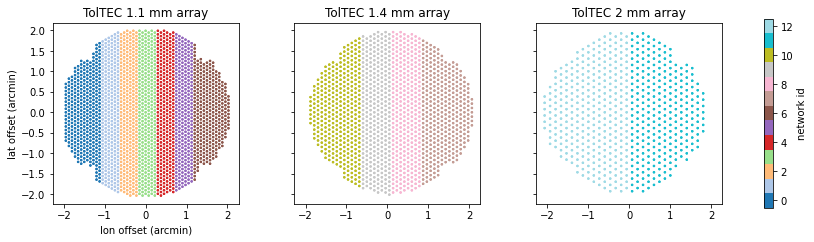

In [12]:
# the columns x_t and y_t (`t` stands for toltec) stores the location of each
# detector on the focal plane, offseted from a fiducial center (co-axial for all three arrays)
# to plot the focal plane for each array.
apt_grps = apt.group_by('array_name').groups
n_arrays = len(apt_grps)
fig, axes = plt.subplots(1, n_arrays, figsize=(15, 4), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.3)
# color map kwargs
n_networks = 13
cm_kwargs = dict(
    cmap=plt.cm.get_cmap('tab20', n_networks),
    vmin=-0.5,
    vmax=n_networks - 0.5
    )
for (ax, (array_name, ), subapt) in zip(axes, apt_grps.keys, apt_grps):
    ax.set_aspect('equal')
    # color code by each detector "network" and toltec has 13 of them
    im = ax.scatter(subapt['x_t'].to_value(u.arcmin), subapt['y_t'].to_value(u.arcmin), s=2, c=subapt['nw'], **cm_kwargs)
    ax.set_title(apt.meta[array_name]['name_long'])
axes[0].set_xlabel('lon offset (arcmin)')
axes[0].set_ylabel('lat offset (arcmin)')
cb = fig.colorbar(im, ax=axes, location='right', shrink=0.87)
cb.set_label('network id')


The default array property table also include a set of fiducial KIDs model parameters. These KIDs model parameters are used to create the KIDs resonator model as well as to simulate the readout circuit. These aspects can be inspected via the ``kidssim`` and ``kids_readout_model`` properties:

sweep data x shape: (7718, 176) S21 shape: (7718, 176)


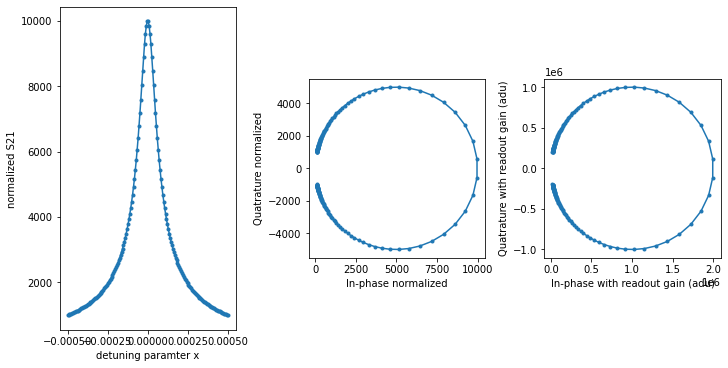

In [13]:
kidssim = simobj.kidssim
print(kidssim)
# plot the resonance circle by simulating a sweep
x, S21 = kidssim.sweep_x(n_steps=176, n_fwhms=10)
print(f'sweep data x shape: {x.shape} S21 shape: {S21.shape}')
# plot the first detectors
fig, axes = plt.subplots(1, 3, constrained_layout=True, figsize=(10, 5))
# f-S21 plane
ax = axes[0]
ax.plot(x[0], np.abs(S21[0]), marker='.')
ax.set_xlabel('detuning paramter x')
ax.set_ylabel('normalized S21')
# I-Q plane
ax = axes[1]
ax.set_aspect('equal')
ax.plot(S21[0].real, S21[0].imag, marker='.')
ax.set_xlabel('In-phase normalized')
ax.set_ylabel('Quatrature normalized')
# the kids readout model mix the normalized S21 with the readout circuit signatures.
# in the kids model we use here, this is just a gain factor but in the actual TolTEC readout
# system, the readout model is much more complicated
ax = axes[2]
ax.set_aspect('equal')
# note the readout model need additionally the actual readout frequencies as the inputs
# we compute f from the x values following the definition of x := f/fr - 1
S21_readout = simobj.kids_readout_model(S21, (x + 1) * kidssim.fr[:, np.newaxis])
# note on the plot below how the value range is different
ax.set_xlabel('In-phase with readout gain (adu)')
ax.set_ylabel('Quatrature with readout gain (adu)')
ax.plot(S21_readout[0].real, S21_readout[0].imag, marker='.')

The routine that puts all the pieces together are methods ``mapping_context`` and ``probe_context``. It does the actual compuation for given source model and mapping pattern. Below we demonstrate some of the internals of these methods:

mapping evaluator: <function ToltecObsSimulator.mapping_context.<locals>.evaluate at 0x137d1caf0>
signal shape: (7718, 500), unit: MJy / sr
obs_info keys: dict_keys(['t', 'time_obs', '_ref_frame', '_ref_coord', 'obs_coords', 'hold_flags', 'm_proj_icrs', 'm_proj_native', 'projected_frame', 'native_frame', 'obs_coords_icrs', '_altaz_frame', 'obs_coords_altaz', 'obs_parallactic_angle', 'a', 'm_rot_m3', 'x', 'y', 'lon', 'lat', 'az', 'alt', 's_additive', 's', 'm_source', 'mapping', 'ref_coord', 'ref_frame', 'self', 'sources', 't0', 'tbl', 'x_t', 'y_t'])


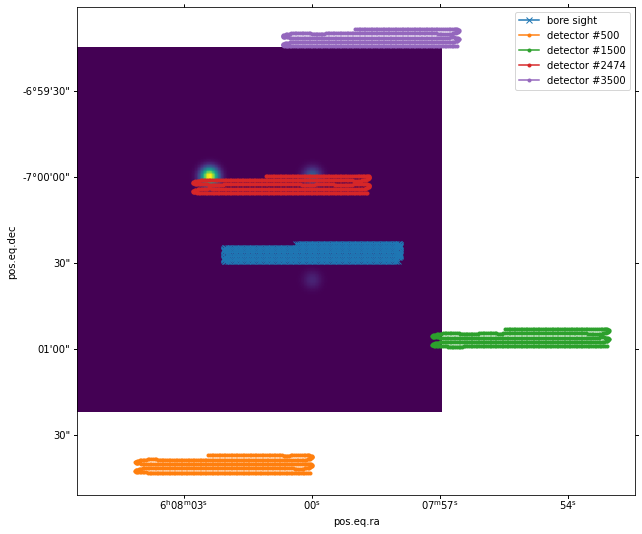

In [14]:
with simobj.mapping_context(mapping=mapping, sources=sources) as mapping_evaluator:
    # obs is a callable that takes time delta, and produces the time ordered data sampled from the sources
    # with the mapping pattern
    print(f'mapping evaluator: {mapping_evaluator}')
    # for example, we can evaluate the time ordered data for the first 5 seconds, with some fiducial
    # sampling rate 122Hz
    f_smp = 100 << u.Hz
    t = np.arange(0, 5, (1. / f_smp).to_value(u.s)) << u.s
    s, obs_info = mapping_evaluator(t)
    print(f'signal shape: {s.shape}, unit: {s.unit}')
    print(f'obs_info keys: {obs_info.keys()}')
# we can plot some of the TODs on sky with the help of obs info
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=w)
ax.imshow(m_img.data['a1100'].data) # plot the rendered source image in 1.1mm 
# ax.set_aspect('equal')
ax.plot(
    obs_info['obs_coords_icrs'].ra, obs_info['obs_coords_icrs'].dec,
    transform=ax.get_transform('icrs'),
    marker='x', label='bore sight')
# di=2474 is one of the detector that saw the sources
for di in [500, 1500, 2474, 3500]:
    ax.plot(
        obs_info['lon'][:, di], obs_info['lat'][:, di],
        transform=ax.get_transform('icrs'),
        marker='.', label=f'detector #{di}')
ax.legend()

S21 shape: (7718, 500) dtype: complex128


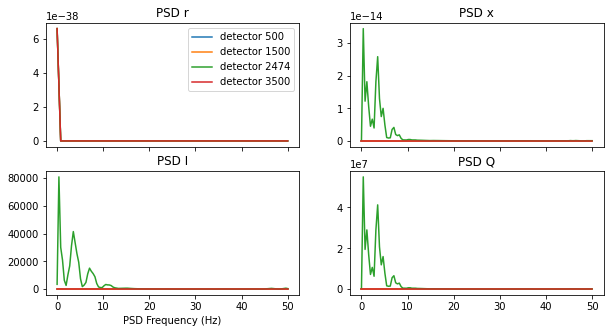

In [15]:
# the probe context returns the kidsdata evaluator, which
# takes the sky signal as input and produce readout timestream
with simobj.probe_context(fp=None) as kidsdata_evaluator:
    r, x, S21, probe_info = kidsdata_evaluator(s)

print(f'S21 shape: {S21.shape} dtype: {S21.dtype}')
# It may be interesting to look at the PSD of the measured time streams
# note that we didn't include any noise so the PSDs will be zero
# for detector that didn't pass the point sources
from scipy import signal

psds = dict()
psd_f, psds['r'] = signal.welch(r, f_smp.to_value(u.Hz))

_, psds['x'] = signal.welch(x, f_smp.to_value(u.Hz))
_, psds['I'] = signal.welch(S21.real, f_smp.to_value(u.Hz))
_, psds['Q'] = signal.welch(S21.imag, f_smp.to_value(u.Hz))
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(10, 5))
axes[-1, 0].set_xlabel('PSD Frequency (Hz)')
for ax, (label, psd) in zip(axes.ravel(), psds.items()):
    ax.set_title(f'PSD {label}')
    # di=2474 is one of the detector that saw the sources.
    for di in [500, 1500, 2474, 3500]:
        ax.plot(psd_f, psd[di], label=f'detector {di}')
axes[0, 0].legend()

To simulator an entire observation and save the data to data file, `tolteca.simu` provides a convenient interface `SimulatorRuntime.run`. The method implement the end-to-end work flow that ties the mapping pattern, the source models, the instrument simulator engine, as well as the data output module.

In [16]:
result = rc.run()
print(result)

SimulatorResult(_iterdata=<generator object SimulatorRuntime.run.<locals>.data_generator at 0x13da2c350>, _lazy=True, config={'my_info': {'foo': 'bar'}, 'setup': {'baz': 'boo', 'created_at': '2021-06-19T01:54:14.328', 'version': '0.1.dev323+g1c6dc6b'}, 'simu': {'jobkey': 'toltec_point_source', 'sources': [{'filepath': 'toltec_sources.asc', 'grouping': 'array_name', 'type': 'point_source_catalog', 'colname_map': {'a1100': 'flux_a1100', 'a1400': 'flux_a1400', 'a2000': 'flux_a2000', 'dec': 'dec', 'name': 'name', 'ra': 'ra'}}, {'atm_model_name': 'am_q50', 'type': 'toltec_array_loading'}], 'instrument': {'calobj': 'cal/calobj_default/index.yaml', 'name': 'toltec'}, 'mapping': {'length': '1. arcmin', 'n_scans': 40, 'ref_frame': 'icrs', 'rot': '0. deg', 'space': '1.5 arcsec', 'speed': '1. arcmin/s', 't0': datetime.datetime(2020, 4, 12, 0, 0), 't_turnover': '0.1 s', 'target': '92d -7d', 'type': 'tolteca.simu:SkyRasterScanModel'}, 'obs_params': {'f_smp_data': <Quantity 122. Hz>, 'f_smp_mapping'

The above line creates the `tolteca.simu.SimulatorResult` instance which holds the result. The result can be marked as either ``lazy`` or not. In the lazy case (our case, as indicated by the ``lazy`` attribute), the actual simulation is run when the `SimulatorResult.save` method is called, and the simulation will be run in chunks, to allow simulating a lot of data that cannot be held in the memory at once:

In [17]:
outdir = rc.get_or_create_output_dir()
result.save(outdir)
print(f'saved simulated data to {outdir}')

saved simulated data to /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/toltec_point_source


The files created are listed as below. The `apt_*.ecsv` is the array property table, and the `toltec*_.nc` are the raw KIDs data:

In [18]:
from tollan.utils.fmt import pformat_paths
print(pformat_paths(outdir.glob('*'), relative_to=outdir, sort=True))

apt_000001_000_0000_2021_06_19_01_54_24.ecsv
simresult.state
tel_000001_000_0000_2021_06_19_01_54_24.nc
toltec0_000001_000_0000_2021_06_19_01_54_24_timestream.nc
toltec10_000001_000_0000_2021_06_19_01_54_24_timestream.nc
toltec11_000001_000_0000_2021_06_19_01_54_24_timestream.nc
toltec12_000001_000_0000_2021_06_19_01_54_24_timestream.nc
toltec1_000001_000_0000_2021_06_19_01_54_24_timestream.nc
toltec2_000001_000_0000_2021_06_19_01_54_24_timestream.nc
toltec3_000001_000_0000_2021_06_19_01_54_24_timestream.nc
toltec4_000001_000_0000_2021_06_19_01_54_24_timestream.nc
toltec5_000001_000_0000_2021_06_19_01_54_24_timestream.nc
toltec6_000001_000_0000_2021_06_19_01_54_24_timestream.nc
toltec7_000001_000_0000_2021_06_19_01_54_24_timestream.nc
toltec8_000001_000_0000_2021_06_19_01_54_24_timestream.nc
toltec9_000001_000_0000_2021_06_19_01_54_24_timestream.nc
tolteca.yaml


At this poin, we've done creating our simulated data. It is noted that the various inspection and plotting is for the educational purpose of the tutorial, exposing the under-the-hood machineries.

For doing the simulation in production, one just need to create a ``SimulatorRuntime`` object, call the ``SimulatorRuntime.run`` method, finally the ``SimulatorResult.save``.

To make it even easier, the `tolteca.cli` module provides a command line interface to invoke the simulator work flow:

```
$ cd some_tolteca_workdir
$ tolteca simu
```

## Reduce the simulated observation

The data reduction is done by using the `tolteca.reduce.PipelineRuntime`, a subclass of the `tolteca.utils.RuntimeContext` object that we should now already be familar with. To create the pipeline runtime,

In [19]:
from tolteca.reduce import PipelineRuntime
prc = PipelineRuntime(rootpath=workdir)
print(f'Created pipeline runtime {prc}')
print(f'Config files in the rc: {prc.config_files}')
print(f'Config:\n{pformat_yaml(prc.config)}')

Created pipeline runtime PipelineRuntime(/private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf)
Config files in the rc: [PosixPath('/private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/50_setup.yaml'), PosixPath('/private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/60_simu.yaml')]


SchemaMissingKeyError: Missing key: 'reduce'

The reason of the exception is that we have not "setup" the pipeline properly. The pipeline expects a branch of config entries under the key ``reduce``, stored in one of the YAML files found in the workdir.

The tolteca.reduce has a set of "built-in" configurations that one can use readily, one of which is 'toltec_point_source'. Let's dump this config to the workdir with file name "80_reduce.yaml". Note the format ``\d+_.+.yaml``, this is the convention of the YAML config files to be recongnized by the tolteca runtime context. The files with lower number are overriden by those with higher number.

In [20]:
from tolteca.reduce import example_configs as cfgs
cfg = cfgs['toltec_citlali_simple']
# here we need to update the input path field to match the simu outdir
cfg['reduce']['inputs'][0]['path'] = rc.config['simu']['jobkey']
# and we set the jobkey to something more sensible
cfg['reduce']['jobkey'] = 'toltec_point_source_reduced'
print(pformat_yaml(cfg))

import yaml
with open(rc.rootpath.joinpath('80_reduce.yaml'), 'w') as fo:
    yaml.dump(cfg, fo)


reduce:
  inputs:
    - path: toltec_point_source
  jobkey: toltec_point_source_reduced
  pipeline:
    config:
      kids:
        fitter:
          modelspec: gainlintrend
          weight_window:
            fwhm_Hz: 1.5e4
            type: lorentz
        solver:
      map:
        grouping: array_name
        mgrid0: 0.0
        mgrid1: 0.0
        offset: 0.0
        pattern: Raster
        pixelsize: 0.75
        type: RaDec
      runtime:
        ncores: 1
        policy: seq
      tod:
        despike:
          despikewindow: 32
          enabled: false
          sigma: 8.0
          timeconstant: 0.015
        downsample:
          downsamplefactor: 1
          enabled: true
        filter:
          agibbs: 50.0
          enabled: false
          fhigh: 4.0
          flow: 0.0
          nterms: 32
        kernel:
          enabled: true
        pcaclean:
          approximateWeights: 0
          cutStd: 0.0
          enabled: false
          grouping: array_name
          

In [21]:
# now we are ready to load the pipeline runtime:
prc = PipelineRuntime(rootpath=workdir)
print(f'Created pipeline runtime {prc}')
print(f'Config files in the rc: {prc.config_files}')
print(f'Config:\n{pformat_yaml(prc.config)}')

Created pipeline runtime PipelineRuntime(/private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf)
Config files in the rc: [PosixPath('/private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/50_setup.yaml'), PosixPath('/private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/60_simu.yaml'), PosixPath('/private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/80_reduce.yaml')]
Config:

my_info:
  foo: bar
reduce:
  inputs:
    - path: toltec_point_source
  jobkey: toltec_point_source_reduced
  pipeline:
    config:
      kids:
        fitter:
          modelspec: gainlintrend
          weight_window:
            fwhm_Hz: 1.5e4
            type: lorentz
        solver:
      map:
        grouping: array_name
        mgrid0: 0.0
        mgrid1: 0.0
        offset: 0.0
        pattern: Raster
        pixelsize: 0.75
        type: RaDec
      runtime:
        ncores: 1
        policy: seq
      tod:
        despike:
          despikewindow: 32

The pipeline runtime handles the execution of the underlying pipeline engine, which is specified to be ``citlali`` in our case. To proceed, we need to make available the citlali executable to the tolteca. This can be conveniently done with the helper function `RuntimeContext.link_to_bindir`:

We can inspect the configurations and the engine itself as follows:

In [22]:
# In the environment this tutorial gets rendered, we the compiled citlali
# executable is in ~/Codes/toltec/cpp/citlali/build/bin
from pathlib import Path
citlali_exec = Path('~/Codes/toltec/cpp/citlali/build/bin/citlali').expanduser()
prc.symlink_to_bindir(citlali_exec, link_name='citlali')

PosixPath('/private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/bin/citlali')

In [23]:
ppl_params = prc.get_pipeline_params()
print(pformat_yaml(ppl_params))
# we can inspect the engine version
engine = ppl_params['engine']
print(f'engine version: {engine.version}')


config:
  kids:
    fitter:
      modelspec: gainlintrend
      weight_window:
        fwhm_Hz: 1.5e4
        type: lorentz
    solver:
  map:
    grouping: array_name
    mgrid0: 0.0
    mgrid1: 0.0
    offset: 0.0
    pattern: Raster
    pixelsize: 0.75
    type: RaDec
  runtime:
    ncores: 1
    policy: seq
  tod:
    despike:
      despikewindow: 32
      enabled: false
      sigma: 8.0
      timeconstant: 0.015
    downsample:
      downsamplefactor: 1
      enabled: true
    filter:
      agibbs: 50.0
      enabled: false
      fhigh: 4.0
      flow: 0.0
      nterms: 32
    kernel:
      enabled: true
    pcaclean:
      approximateWeights: 0
      cutStd: 0.0
      enabled: false
      grouping: array_name
      neigToCut: 9
engine: Citlali(/private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpiz6lrhdf/bin/citlali,version=cc27f77)
name: citlali

engine version: cc27f77


To run the pipelin, simply do:

In [24]:
result = prc.run()

/usr/local/Cellar/python@3.8/3.8.10/Frameworks/Python.framework/Versions/3.8/lib/python3.8/subprocess.py:848: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)
** logging ** configured with level=debug (debug at compile time; available levels: {trace, debug, info, warning, error, critical, off})
[2021-06-18 21:55:26.570] [info] [logging.h:129] **timeit** Citlali Process
[2021-06-18 21:55:26.570] [info] [main.cpp:81] reconfigure logger to level=error



The files created are listed as below. The `citlali.ecsv` is the low level config file supplied to the citlali call, and the `toltec*_.fits` are the reduced maps.

In [25]:
outdir = result['outdir']
print(pformat_paths(outdir.glob('*'), relative_to=outdir, sort=True))

citlali.yaml
toltec_simu_a1100_science_000001_451129.fits
toltec_simu_a1400_science_000001_451129.fits
toltec_simu_a2000_science_000001_451129.fits


We can now load back the reduced files and see the sources that we initialy put into the simulation.

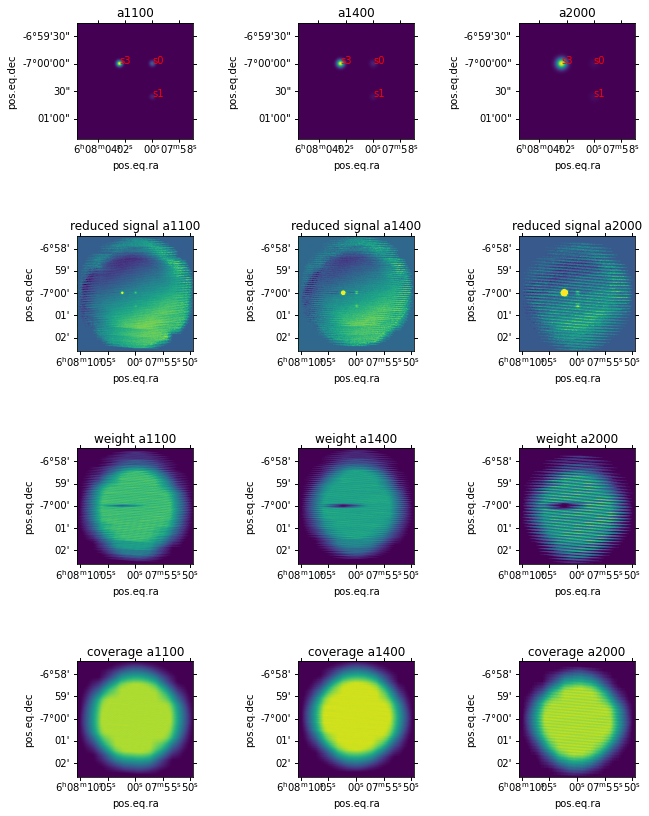

In [26]:
from astropy.io import fits
from astropy.visualization import PercentileInterval, ImageNormalize, MinMaxInterval
interval = PercentileInterval(99)

fig = plt.figure(figsize=(10, 15))
fig.subplots_adjust(wspace=0.9)
n_hdus = len(m_img.data)

for i, (k, hdu) in enumerate(m_img.data.items()):
    w = WCS(hdu.header)
    ax = fig.add_subplot(4, n_hdus, i + 1, projection=w)
    ax.set_aspect('equal')
    ax.set_title(f'{k}')
    ax.imshow(hdu.data)
    # label the sources
    for p, n in zip(m_point_source.pos, m_point_source.data['name']):
        ax.text(p.ra.degree, p.dec.degree, n, transform=ax.get_transform('icrs'), color='red')
    # load the output fits file and plot
    hl = fits.open(list(outdir.glob(f'*_{k}_*.fits'))[-1])
    for j, (e, label) in enumerate(zip([1, 2, 4], ['reduced signal', 'weight', 'coverage'])):  # signal (1), weight (2), and int 4
        hdu = hl[e]
        w = WCS(hdu.header)  # signal map is extension 1
        ax = fig.add_subplot(4, n_hdus, n_hdus * (j + 1) + i + 1, projection=w)
        ax.set_title(f'{label} {k}')
        norm = ImageNormalize(hdu.data, interval=interval)
        ax.imshow(hdu.data, norm=norm)

The reduced fits images are not scaled for this current version. To compare the photometry, we would need to get the array property table generated along with the simulation.

flxscale for a1100: 5.098e+08
beam fwhm: 5.0 arcsec
beam fwhm_pix: 6.666666666666678
 id        x_0               y_0              flux_fit          flux_unc     
--- ----------------- ------------------ ----------------- ------------------
  1             208.0 208.99999999998315 28.56421469089193  1.380004503526395
  2             208.0 160.99999951253713 7.629850733533558 1.1676561664618719
  3 160.3577842481555  208.9994933199453 94.72110882551806  1.233727011999882
flxscale for a1400: 1.419e+08
beam fwhm: 6.363636363636363 arcsec
beam fwhm_pix: 8.484848484848499
 id        x_0               y_0              flux_fit           flux_unc     
--- ----------------- ------------------ ------------------ ------------------
  1             208.0 208.99999999998315 15.882790050531957 0.8481032372796768
  2             208.0 160.99999951253713 11.935297012881708 0.6562547195562568
  3 160.3577842481555  208.9994933199453  194.1907890149215 0.8911149184938396
flxscale for a2000: 6.13e+07
be

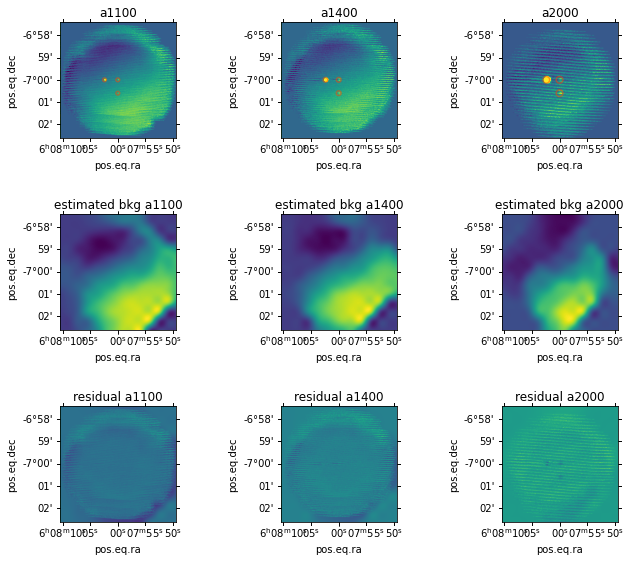

In [27]:
# note the [0-9] in the glob pattern. this is to not select the _trimmed.ecsv file that are used internally
# by the tolteca.reduce and citlali
apt = Table.read(next(iter(rc.get_or_create_output_dir().glob('apt_000001_*[0-9].ecsv'))), format='ascii')
# print(apt['flxscale'])
# we can apply the flxscale to the signal images and try do the photometry

from photutils.psf import DAOGroup
from photutils.psf import (
            IntegratedGaussianPRF,
            BasicPSFPhotometry)
from photutils.background import MMMBackground
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import SigmaClip
from photutils.background import Background2D
from astropy.modeling.functional_models import GAUSSIAN_SIGMA_TO_FWHM
from photutils import CircularAperture

# %matplotlib widget
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(wspace=0.9)

for i, k in enumerate(['a1100', 'a1400', 'a2000']):
    scale = apt['flxscale'][apt['array_name'] == k][0] # in this version the flxscale is shared acorss each array so we just take first one.
    print(f"flxscale for {k}: {scale:.4g}")
    hl = fits.open(list(outdir.glob(f'*_{k}_*.fits'))[-1])
    # hl.info()
    hdu = hl[1]  # signal
    w = WCS(hdu.header)  # used this to get xy from source position

    ax = fig.add_subplot(3, 3, i + 1, projection=w)
    ax.set_aspect('equal')
    ax.set_title(f'{k}')
    norm = ImageNormalize(hdu.data, interval=interval)
    ax.imshow(hdu.data, norm=norm)
    # we can find some of the array facts in the beam model
    fwhm = BeamModel().models[k].x_fwhm
    print(f'beam fwhm: {fwhm}')
    pixscale = u.pixel_scale(w.proj_plane_pixel_scales()[0] / u.pix)
    fwhm_pix = fwhm.to_value(u.pix, equivalencies=pixscale)
    print(f'beam fwhm_pix: {fwhm_pix}')

    # source catalog
    x_src, y_src = w.all_world2pix(m_point_source.pos.ra.degree, m_point_source.pos.dec.degree, 0)
    xy = Table(names=['x_0', 'y_0'], data=[x_src, y_src])
    # print(xy)

    # Plot an overlay on the source
    apertures = CircularAperture(np.transpose((x_src, y_src)), r=fwhm_pix)
    apertures.plot(axes=ax, color='#ff4400', lw=1.5, alpha=0.5)
    
    # scale the data and do PSF photometry to check the recovered flux
    # the scale will put data in MJy/sr and
    # here we convert to mJy/beam, so the photometry will recover the flux in mJy
    beam_area = 2 * np.pi * (fwhm / GAUSSIAN_SIGMA_TO_FWHM) ** 2
    arcsec_per_pix = (1 << u.pix).to_value(u.arcsec, equivalencies=pixscale)
    data = ((hdu.data * scale) << u.MJy / u.sr).to_value(u.mJy/u.arcsec ** 2) * arcsec_per_pix ** 2 
    
    # .to_value(u.mJy/u.beam, equivalencies=u.beam_angular_area(beam_area))

    psf_model = IntegratedGaussianPRF(sigma=fwhm_pix / GAUSSIAN_SIGMA_TO_FWHM)
    daogroup = DAOGroup(1.0)  # 1 pix. this will not group the sources separated larger then 1 pix
    mmm_bkg = MMMBackground()
    fit_size = int(fwhm_pix * 3.)  # fit box of 3 * fwhm
    if fit_size % 2 == 0:
        fit_size += 1
    photometry = BasicPSFPhotometry(
                        group_maker=daogroup, bkg_estimator=mmm_bkg,
                        psf_model=psf_model,
                        fitter=LevMarLSQFitter(),
                        fitshape=(fit_size, fit_size))
    
    # the bkg is not uniform, so try to get an approximation of it and subtract
    sigma_clip = SigmaClip(sigma=3.)
    bkg = Background2D(data, (30, 30), filter_size=(3, 3),
                       sigma_clip=sigma_clip, bkg_estimator=mmm_bkg)
    ax = fig.add_subplot(3, 3, 3 + i + 1, projection=w)
    ax.imshow(bkg.background)
    ax.set_title(f'estimated bkg {k}')
    catalog = photometry(
        image=data - bkg.background,
        init_guesses=xy)
    # plot residual
    ax = fig.add_subplot(3, 3, 6 + i + 1, projection=w)
    ax.imshow(photometry.get_residual_image())
    print(catalog[['id', 'x_0', 'y_0', 'flux_fit', 'flux_unc']])
    ax.set_title(f'residual {k}')